# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from Kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications, we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

##### The goal is to develop a predictive model that identifies the key variables influencing the price of a used car. This involves analyzing a dataset containing various features of used cars (e.g., make, model, year, mileage, condition) to determine which attributes are most strongly correlated with car price. The task includes feature selection, data preprocessing, and regression modeling to quantify the impact of different factors on car valuation. The final output should provide insights that guide the dealership in pricing strategies and inventory acquisition based on consumer preferences.

### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LassoCV, LinearRegression, Lasso, Ridge
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split,cross_val_score, GridSearchCV

In [13]:
df = pd.read_csv("./data/vehicles.csv")  

In [14]:
df.head()

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
0,7222695916,prescott,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,az
1,7218891961,fayetteville,11900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ar
2,7221797935,florida keys,21000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fl
3,7222270760,worcester / central MA,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ma
4,7210384030,greensboro,4900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nc


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

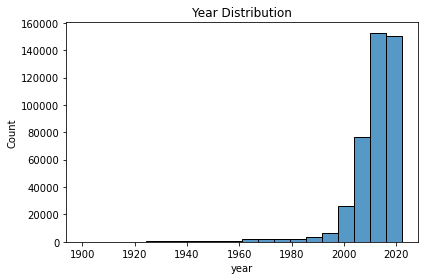

In [16]:
#distribution of year
sns.histplot(df['year'], bins=20)
plt.title("Year Distribution")
plt.tight_layout()
plt.show()

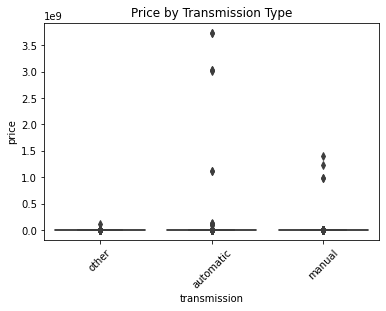

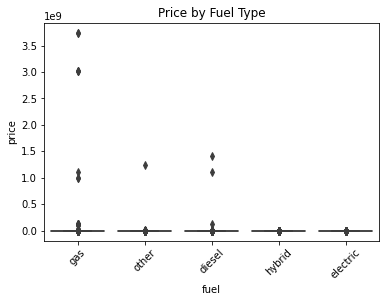

In [17]:
# Transmission type
sns.boxplot(data=df, x='transmission', y='price')
plt.title("Price by Transmission Type")
plt.xticks(rotation=45)
plt.show()

# Fuel type
sns.boxplot(data=df, x='fuel', y='price')
plt.title("Price by Fuel Type")
plt.xticks(rotation=45)
plt.show()

### Data Preparation

After our initial exploration and fine-tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

In [18]:
df.isnull().sum().sort_values(ascending=False)

size            306361
cylinders       177678
condition       174104
VIN             161042
drive           130567
paint_color     130203
type             92858
manufacturer     17646
title_status      8242
model             5277
odometer          4400
fuel              3013
transmission      2556
year              1205
id                   0
region               0
price                0
state                0
dtype: int64

In [19]:
print(df['manufacturer'].value_counts())

#convert manufacturer column into manageable categorical variable so it doesn't generate
#so many columns during one-hot encoding

manufacturer_categories = {
    'ford': 'economy',
    'chevrolet': 'economy',
    'toyota': 'economy',
    'honda': 'economy',
    'jeep': 'luxury_suv',
    'nissan': 'economy',
    'ram': 'economy',
    'gmc': 'economy',
    'unknown': 'other',
    'bmw': 'luxury',
    'dodge': 'economy',
    'mercedes-benz': 'luxury',
    'hyundai': 'economy',
    'subaru': 'economy',
    'volkswagen': 'economy',
    'lexus': 'luxury',
    'kia': 'economy',
    'audi': 'luxury',
    'cadillac': 'luxury',
    'acura': 'luxury',
    'chrysler': 'economy',
    'buick': 'economy',
    'mazda': 'economy',
    'infiniti': 'luxury',
    'lincoln': 'luxury',
    'volvo': 'luxury',
    'mitsubishi': 'economy',
    'mini': 'luxury',
    'pontiac': 'economy',
    'rover': 'luxury_suv',
    'jaguar': 'luxury',
    'porsche': 'luxury',
    'mercury': 'economy',
    'saturn': 'economy',
    'alfa-romeo': 'luxury',
    'tesla': 'luxury',
    'fiat': 'economy',
    'harley-davidson': 'other',
    'ferrari': 'sports',
    'datsun': 'economy',
    'aston-martin': 'sports',
    'land rover': 'luxury_suv',
    'morgan': 'sports'
}

df['manufacturer'] = df['manufacturer'].map(manufacturer_categories).fillna('other')

# Check the updated values
print(df['manufacturer'].value_counts())


ford               70985
chevrolet          55064
toyota             34202
honda              21269
nissan             19067
jeep               19014
ram                18342
gmc                16785
bmw                14699
dodge              13707
mercedes-benz      11817
hyundai            10338
subaru              9495
volkswagen          9345
kia                 8457
lexus               8200
audi                7573
cadillac            6953
chrysler            6031
acura               5978
buick               5501
mazda               5427
infiniti            4802
lincoln             4220
volvo               3374
mitsubishi          3292
mini                2376
pontiac             2288
rover               2113
jaguar              1946
porsche             1384
mercury             1184
saturn              1090
alfa-romeo           897
tesla                868
fiat                 792
harley-davidson      153
ferrari               95
datsun                63
aston-martin          24


In [20]:
# Handle Missing Values 

# Drop 'id' and 'VIN' columns — not useful for prediction and VIN has lots of missing values
df.drop(columns=['id', 'VIN'], inplace=True)

# Drop rows with missing 'price' and 'year'
df = df.dropna(subset=['price','year'])

# Drop 'size', 'paint_color', 'type' columns with too many missing values
df = df.drop(columns=['size', 'paint_color', 'type'])


# Insert 'unknown' into missing categorical values (for critical features)
cat_features = ['condition', 'drive', 'manufacturer', 'fuel', 'transmission']
df[cat_features] = df[cat_features].fillna('unknown')

# Fill missing numerical values (odometer) with median
df['odometer'] = df['odometer'].fillna(df['odometer'].median())

# Feature Engineering
# create a Age of car column (current year - year of manufacture) since thats more useful than year
df['car_age'] = 2025 - df['year']
df['car_age'] = df['car_age'].fillna(df['car_age'].median())  # Fill missing age with median
df = df.drop(columns=['year'])  # 'car_age' is more useful

# Remove cars with price = 0 (outliers)
df = df[df['price'] > 0]

# logarithmize the price and odometer column
df['price'] = np.log1p(df['price'])
df['odometer'] = np.log1p(df['odometer'])


#convert condition into a numerical variable and explore its effect with age
df['condition_age_interaction'] = df['condition'].map({
    'new': 1,
    'like new': 0.8,
    'good': 0.6,
    'excellent': 0.7,  
    'fair': 0.4,
    'salvage': 0.2,
    'unknown': 0  
}) * df['car_age']

#Transformations
num_features = ['condition_age_interaction','price', 'car_age', 'odometer']
cat_features = ['drive', 'fuel', 'transmission','manufacturer']

pipeline = Pipeline(steps=[
    ('preprocessor', ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), num_features),  # Standardize numerical features
            ('cat', OneHotEncoder(drop='first'), cat_features)  # One-Hot Encode categorical features
        ]
    ))
])

# Apply the pipeline to transform the dataset
df_processed = pipeline.fit_transform(df)

# Get the feature names from the OneHotEncoder
cat_feature_names = pipeline.named_steps['preprocessor'].transformers_[1][1].get_feature_names(cat_features)

# Combine numerical and categorical feature names
feature_names = num_features + list(cat_feature_names)

# Convert the transformed data back into a DataFrame
df_processed = pd.DataFrame(df_processed, columns=feature_names)

print(df_processed.info())
print(df_processed.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 392812 entries, 0 to 392811
Data columns (total 19 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   condition_age_interaction  392812 non-null  float64
 1   price                      392812 non-null  float64
 2   car_age                    392812 non-null  float64
 3   odometer                   392812 non-null  float64
 4   drive_fwd                  392812 non-null  float64
 5   drive_rwd                  392812 non-null  float64
 6   drive_unknown              392812 non-null  float64
 7   fuel_electric              392812 non-null  float64
 8   fuel_gas                   392812 non-null  float64
 9   fuel_hybrid                392812 non-null  float64
 10  fuel_other                 392812 non-null  float64
 11  fuel_unknown               392812 non-null  float64
 12  transmission_manual        392812 non-null  float64
 13  transmission_other         39

In [21]:
X = df_processed.drop(columns='price')
y = df_processed['price']

#Split into train and test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("X_train: ")
print(X_train.head())

print("X_test: ")
print(X_test.head())

print("y_train: ")
print(y_train.head())

print("y_test: ")
print(y_test.head())

X_train: 
        condition_age_interaction   car_age  odometer  drive_fwd  drive_rwd  \
91565                   -0.840963 -0.414695  0.428063        0.0        0.0   
372711                  -0.840963 -0.726193 -0.113598        1.0        0.0   
306555                   0.385643 -0.207030  0.725248        1.0        0.0   
275163                   1.144970  0.312133  0.182264        1.0        0.0   
48088                   -0.052431 -0.518528 -0.056904        0.0        0.0   

        drive_unknown  fuel_electric  fuel_gas  fuel_hybrid  fuel_other  \
91565             1.0            0.0       1.0          0.0         0.0   
372711            0.0            0.0       1.0          0.0         0.0   
306555            0.0            0.0       1.0          0.0         0.0   
275163            0.0            0.0       1.0          0.0         0.0   
48088             1.0            0.0       0.0          0.0         1.0   

        fuel_unknown  transmission_manual  transmission_other  \

### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

In [22]:
#Use linear regression, lasso, and ridge models
models = {
    'Linear Regression': LinearRegression(),
    'Lasso Regression': Lasso(),
    'Ridge Regression': Ridge()
}

#Train and evaluate models using cross-validation with mean_squared_error as scoring
model_results = []

for name, model in models.items():
    print(f"Training {name}...")
    
    # Cross-validation to evaluate models using mean_squared_error as the scoring metric
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    mean_cv_score = np.mean(cv_scores)  # Convert to positive MSE
    
    # Train the model on the entire training data
    model.fit(X_train, y_train)
    
    coefficients = pd.Series(model.coef_, index=X_train.columns)
    print(coefficients.sort_values())
    
    # Make predictions on the test set
    y_pred = model.predict(X_test)
    
    # Evaluation metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    
    model_results.append({
        'Model': name,
        'Mean CV MSE': -mean_cv_score,  # Converting negative MSE to positive
        'Test MAE': mae,
        'Test MSE': mse,
    })

model_comparison = pd.DataFrame(model_results)
print(model_comparison)

# Hyperparameter tuning for Lasso and Ridge Regression using GridSearchCV
param_grid_lasso = {'alpha': np.logspace(-4, 4, 20)}  # Regularization strength for Lasso
param_grid_ridge = {'alpha': np.logspace(-4, 4, 20)}  # Regularization strength for Ridge

# Lasso Regression - Grid Search
lasso = Lasso()
lasso_grid_search = GridSearchCV(lasso, param_grid_lasso, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
lasso_grid_search.fit(X_train, y_train)
print("Best alpha for Lasso:", lasso_grid_search.best_params_['alpha'])

# Ridge Regression - Grid Search
ridge = Ridge()
ridge_grid_search = GridSearchCV(ridge, param_grid_ridge, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
ridge_grid_search.fit(X_train, y_train)
print("Best alpha for Ridge:", ridge_grid_search.best_params_['alpha'])

# Re-train models with best hyperparameters
lasso_best = lasso_grid_search.best_estimator_
ridge_best = ridge_grid_search.best_estimator_

# Re-train models on the entire training set
lasso_best.fit(X_train, y_train)
ridge_best.fit(X_train, y_train)


lasso_coefficients = pd.Series(lasso_best.coef_, index=X_train.columns)
print("Lasso Best Model Coefficients: ")
print(lasso_coefficients.sort_values())

ridge_coefficients = pd.Series(ridge_best.coef_, index=X_train.columns)
print("Ridge Best Model Coefficients: ")
print(ridge_coefficients.sort_values())

# Make predictions on the test set
lasso_pred = lasso_best.predict(X_test)
ridge_pred = ridge_best.predict(X_test)

# Evaluate performance of the tuned models
lasso_mae = mean_absolute_error(y_test, lasso_pred)
ridge_mae = mean_absolute_error(y_test, ridge_pred)

lasso_mse = mean_squared_error(y_test, lasso_pred)
ridge_mse = mean_squared_error(y_test, ridge_pred)


# Display results for the tuned models
final_results = pd.DataFrame({
    'Model': ['Lasso Regression', 'Ridge Regression'],
    'Test MAE': [lasso_mae, ridge_mae],
    'Test MSE': [lasso_mse, ridge_mse]
})

print(final_results)

Training Linear Regression...
fuel_gas                    -0.653036
fuel_hybrid                 -0.610448
fuel_electric               -0.600614
fuel_other                  -0.442721
drive_fwd                   -0.409413
fuel_unknown                -0.379323
drive_unknown               -0.261923
car_age                     -0.237560
manufacturer_other          -0.186534
odometer                    -0.114049
manufacturer_luxury_suv     -0.007360
condition_age_interaction    0.008989
drive_rwd                    0.049383
transmission_manual          0.078029
manufacturer_luxury          0.105885
transmission_unknown         0.225990
transmission_other           0.411769
manufacturer_sports          1.433143
dtype: float64
Training Lasso Regression...
condition_age_interaction   -0.0
manufacturer_luxury_suv      0.0
manufacturer_luxury          0.0
transmission_unknown         0.0
transmission_other           0.0
transmission_manual         -0.0
fuel_unknown                 0.0
fuel_other 

### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high-quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight into drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

#### What Makes a High-Quality Model in This Case?
A high-quality model should not only predict used car prices with strong accuracy but also be interpretable and aligned with the dealership’s business goals. In this project, the best-performing models were Linear Regression and Ridge Regression, both achieving:

Mean Absolute Error (MAE): ~0.52 (on log-transformed prices)

This translates to an average prediction error of around $685, which is very reasonable in the context of used car pricing.

Mean Squared Error (MSE): Also low and consistent across training and test sets, indicating good generalization.

#### Model Interpretability & Usefulness
Regularized models (Lasso and Ridge) ensured that the model was not overfitting and highlighted the most influential features in pricing. These include:

Car age and mileage (odometer) — older, higher-mileage cars fetch lower prices.

Condition-age interaction — a unique feature engineered to capture how condition and age jointly affect value.

Drive type and fuel type — preferences for FWD, electric/hybrid vehicles can influence pricing.

Manufacturer category — grouping into "luxury", "sports", etc., improved performance without overcomplicating the model.

#### Revisit Earlier Phases?
No major issues were found that require revisiting prior phases. Missing values were handled effectively, outliers were removed, and categorical features were thoughtfully engineered and encoded. The model captures both prediction performance and business relevance, which means we’re in a strong position to move forward with deployment.

### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine-tuning their inventory.

## 🎯 Objective:
To empower used car dealerships with data-driven insights that enhance pricing strategies and inventory decisions by modeling factors that influence used car prices.

---

## 📈 Key Modeling Findings:

We developed and evaluated three regression models — **Linear Regression**, **Lasso Regression**, and **Ridge Regression** — to predict used car prices based on key vehicle features.

- ✅ **Best Performing Model**: **Ridge Regression**  
- 📉 **Average Error (MAE)**: ~\$685  
- 📊 **Model Reliability**: Consistent cross-validation and test set performance indicated strong generalization and no overfitting.
- 🧰 **Preprocessing**: Features were scaled and encoded to ensure interpretability and fairness under regularization.

---

## 🔍 Business Insights from the Model:

### 1. **Car Age and Condition Matter Most**
- **Car age** had a consistent negative impact across all models — older cars are valued lower.
- The **condition-age interaction** term, though small in magnitude, was retained in the best models, suggesting a compounded effect: **newer vehicles in better condition yield significantly higher prices.**

💡 *Strategy*: Focus on acquiring **newer, well-maintained vehicles**, especially those under **5 years old**, as they provide the best return potential.

---

### 2. **Mileage is a Strong Depreciation Signal**
- The `odometer` feature was negatively correlated with price across all models.  
- Even **low-age vehicles** lose value sharply when mileage exceeds **60,000 miles**.

💡 *Strategy*: Be cautious about stocking **high-mileage cars**, even if they appear newer.

---

### 3. **Drivetrain Preferences Influence Value**
- **FWD (Front-Wheel Drive)** vehicles had consistently **negative coefficients**, but were *less negative* compared to RWD and unknown types.
- Indicates a **slight preference** or better retained value for FWD vehicles, likely due to practicality or regional driving conditions.

💡 *Strategy*: Prioritize **FWD vehicles** in regions with wet or snowy climates where they may be more appealing.

---

### 4. **Fuel Type Patterns Reflect Emerging Trends**
- All non-gas fuel types (electric, hybrid, other) had **negative coefficients**, but the **magnitudes were relatively similar**, suggesting price differences are **not extreme** — yet.
- The Lasso model, when tuned properly, **retained EV and hybrid features**, indicating their relevance under sparse settings.

💡 *Strategy*: Closely monitor and adjust pricing strategies for **electric and hybrid vehicles**, as **demand and retained value are likely to increase** over time.

---

### 5. **Brand Matters — Grouped Manufacturer Signals Work Well**
- Instead of using over 40 individual brands, we grouped them into:  
  - **Luxury (e.g., BMW, Mercedes)**  
  - **Luxury SUV (e.g., Land Rover)**  
  - **Sports (e.g., Porsche, Ferrari)**  
  - **Other/common brands (e.g., Toyota, Ford)**

- The **strongest positive coefficient** was for `manufacturer_sports`, showing these cars command **substantially higher prices**, even after controlling for other features.

💡 *Strategy*: When possible, invest in **sports or luxury vehicles** — even with higher mileage or age, they tend to **retain higher perceived value**.

---

## 🧠 Strategic Takeaways for Dealers:

- ✅ **Inventory Priorities**: Source newer, lower-mileage vehicles in good condition for optimal resale value.
- ⚡ **EV Opportunity**: Stay ahead of electric and hybrid trends. They're gaining traction and may soon hold stronger pricing power.
- 🚘 **Brand Leverage**: Recognize the premium associated with sports and luxury brands — these can justify higher pricing and broader marketing appeal.
- 🌍 **Regional Preferences**: Consider drivetrain preferences when stocking vehicles. FWD may be favored in certain climates.



